In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import datetime as dt 
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like 
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from plotnine import *
import io 
import statistics as st 
%matplotlib inline
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss 
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

In [2]:
# raw data 로딩 
raw_data = pd.read_csv('/content/drive/MyDrive/Dongwon_Project/예측 과제/intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.0,6743


In [ ]:
df = raw_data[['H_YMD', 'O_YMD', 'GOODS_NO', 'ORD_QTY', 'SALE_PRICE', 'REAL_ORD_QTY']]

df = df.sort_values(by = 'H_YMD')

In [ ]:
print('Features:', df.shape[1], ';', 'Entries: ', df.shape[0] )

Features: 6 ; Entries:  724702


In [ ]:
df.describe()

,GOODS_NO,ORD_QTY,SALE_PRICE,REAL_ORD_QTY
count,7.247020e+05,724702.00000,724702.000000,724702.000000
mean,1.042033e+09,1.12172,7262.438891,1.071131
std,9.136080e+08,0.47063,2417.240294,0.497911
min,1.823000e+03,1.00000,2600.000000,0.000000
25%,1.437500e+04,1.00000,4900.000000,1.000000
50%,1.712010e+09,1.00000,7000.000000,1.000000
75%,1.808012e+09,1.00000,8800.000000,1.000000
max,2.204017e+09,45.00000,35600.000000,45.000000


In [ ]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

GOODS_NO = GOODS_DIC.keys()
GOODS_NM = GOODS_DIC.values()

In [ ]:
df = df[df['GOODS_NO']==14375]

df

,H_YMD,O_YMD,GOODS_NO,ORD_QTY,SALE_PRICE,REAL_ORD_QTY
166288,2020-01-01 00:00:00,2019-12-30 21:59:40,14375,1,8600,1
163504,2020-01-01 00:00:00,2019-12-30 19:49:25,14375,1,8600,1
170134,2020-01-01 00:00:00,2019-12-30 20:20:12,14375,1,8600,1
175012,2020-01-01 00:00:00,2019-12-30 22:20:13,14375,2,8600,2
163460,2020-01-01 00:00:00,2019-12-29 00:14:26,14375,1,8600,1
...,...,...,...,...,...,...
234637,2022-05-31 00:00:00,2022-05-27 13:25:46,14375,1,8800,1
234640,2022-05-31 00:00:00,2022-05-30 10:45:41,14375,1,8800,1
234641,2022-05-31 00:00:00,2022-05-30 05:23:01,14375,1,8800,1
233869,2022-05-31 00:00:00,2022-05-28 20:34:33,14375,1,8800,1


In [ ]:
df['H_YMD'] = pd.to_datetime(df['H_YMD'], infer_datetime_format=True)
df

,H_YMD,O_YMD,GOODS_NO,ORD_QTY,SALE_PRICE,REAL_ORD_QTY
166288,2020-01-01,2019-12-30 21:59:40,14375,1,8600,1
163504,2020-01-01,2019-12-30 19:49:25,14375,1,8600,1
170134,2020-01-01,2019-12-30 20:20:12,14375,1,8600,1
175012,2020-01-01,2019-12-30 22:20:13,14375,2,8600,2
163460,2020-01-01,2019-12-29 00:14:26,14375,1,8600,1
...,...,...,...,...,...,...
234637,2022-05-31,2022-05-27 13:25:46,14375,1,8800,1
234640,2022-05-31,2022-05-30 10:45:41,14375,1,8800,1
234641,2022-05-31,2022-05-30 05:23:01,14375,1,8800,1
233869,2022-05-31,2022-05-28 20:34:33,14375,1,8800,1


In [ ]:
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

H_YMD           0.0
O_YMD           0.0
GOODS_NO        0.0
ORD_QTY         0.0
SALE_PRICE      0.0
REAL_ORD_QTY    0.0
dtype: float64

In [ ]:
df.set_index('H_YMD', inplace=True)
df

,O_YMD,GOODS_NO,ORD_QTY,SALE_PRICE,REAL_ORD_QTY
H_YMD,,,,,
2020-01-01,2019-12-30 21:59:40,14375,1,8600,1
2020-01-01,2019-12-30 19:49:25,14375,1,8600,1
2020-01-01,2019-12-30 20:20:12,14375,1,8600,1
2020-01-01,2019-12-30 22:20:13,14375,2,8600,2
2020-01-01,2019-12-29 00:14:26,14375,1,8600,1
...,...,...,...,...,...
2022-05-31,2022-05-27 13:25:46,14375,1,8800,1
2022-05-31,2022-05-30 10:45:41,14375,1,8800,1
2022-05-31,2022-05-30 05:23:01,14375,1,8800,1


In [ ]:
df['Year'] = df.index.year
df['Quarter'] = df.index.quarter
df['Month'] = df.index.month
df['Week'] = df.index.week
df['Weekday'] = df.index.weekday
df['Day'] = df.index.day
df['Dayofyear'] = df.index.dayofyear 
df['Date'] = pd.DatetimeIndex(df.index).date

In [ ]:
df['O_YMD'] = pd.to_datetime(df['O_YMD'])
df['O_YMD'] = df['O_YMD'].dt.weekday

In [ ]:
df

,O_YMD,GOODS_NO,ORD_QTY,SALE_PRICE,REAL_ORD_QTY,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
H_YMD,,,,,,,,,,,,,
2020-01-01,0,14375,1,8600,1,2020,1,1,1,2,1,1,2020-01-01
2020-01-01,0,14375,1,8600,1,2020,1,1,1,2,1,1,2020-01-01
2020-01-01,0,14375,1,8600,1,2020,1,1,1,2,1,1,2020-01-01
2020-01-01,0,14375,2,8600,2,2020,1,1,1,2,1,1,2020-01-01
2020-01-01,6,14375,1,8600,1,2020,1,1,1,2,1,1,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,4,14375,1,8800,1,2022,2,5,22,1,31,151,2022-05-31
2022-05-31,0,14375,1,8800,1,2022,2,5,22,1,31,151,2022-05-31
2022-05-31,0,14375,1,8800,1,2022,2,5,22,1,31,151,2022-05-31


In [ ]:
group_ = ['Date', 'Year', 'Quarter', 'Month', 'Week', 'Weekday', 'Dayofyear', 'Day', 'O_YMD', 'GOODS_NO']

df2 = pd.DataFrame(df.groupby(group_).SALE_PRICE.sum(), columns=['SALE_PRICE'])
df2['REAL_ORD_QTY'] = df.groupby(group_).REAL_ORD_QTY.sum()

df2 = df2.reset_index()
df2

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,O_YMD,GOODS_NO,SALE_PRICE,REAL_ORD_QTY
0,2020-01-01,2020,1,1,1,2,1,1,0,14375,369800,48
1,2020-01-01,2020,1,1,1,2,1,1,1,14375,172000,22
2,2020-01-01,2020,1,1,1,2,1,1,2,14375,8600,2
3,2020-01-01,2020,1,1,1,2,1,1,3,14375,25800,5
4,2020-01-01,2020,1,1,1,2,1,1,4,14375,43000,7
...,...,...,...,...,...,...,...,...,...,...,...,...
4869,2022-05-31,2022,2,5,22,1,151,31,2,14375,35200,2
4870,2022-05-31,2022,2,5,22,1,151,31,3,14375,8800,1
4871,2022-05-31,2022,2,5,22,1,151,31,4,14375,17600,2
4872,2022-05-31,2022,2,5,22,1,151,31,5,14375,114400,14


In [ ]:
df2.loc[:, ['SALE_PRICE', 'REAL_ORD_QTY']].describe()

,SALE_PRICE,REAL_ORD_QTY
count,4.874000e+03,4874.000000
mean,1.996395e+05,25.318629
std,2.496719e+05,32.560875
min,5.600000e+03,0.000000
25%,2.640000e+04,3.000000
50%,8.600000e+04,10.000000
75%,3.080000e+05,38.000000
max,2.029600e+06,254.000000


In [ ]:
def _fig_plot(df, X, Y):
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16) 
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis() 

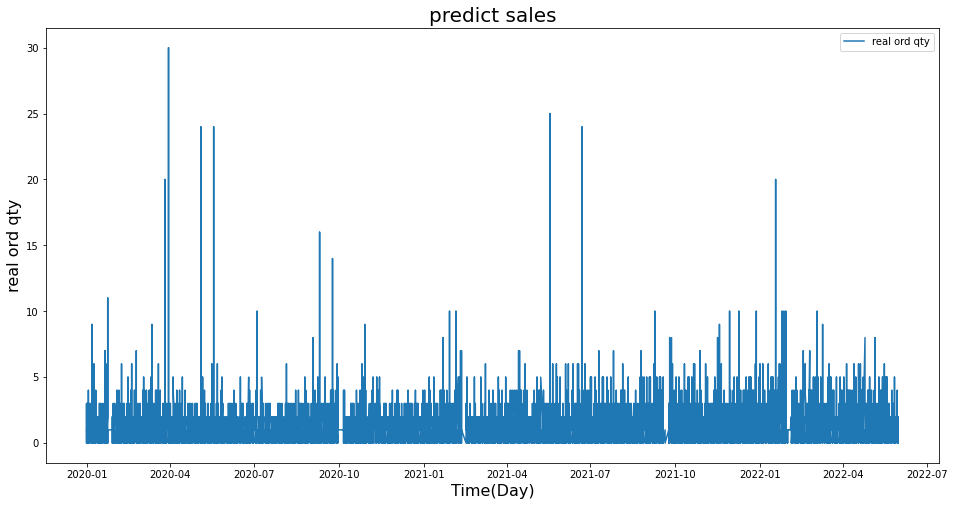

In [ ]:
X = 'Date'
Y = 'REAL_ORD_QTY'
Label = "real ord qty"
Figsize = (16, 8)
Title = 'predict sales'
xAxisLabel = "Time(Day)"
yAxisLabel = 'real ord qty'
_fig_plot(df, X, Y)


In [ ]:
low_roq = df2.REAL_ORD_QTY.quantile(0.01)
high_roq = df2.REAL_ORD_QTY.quantile(0.99)
print(low_roq, high_roq)

0.0 147.53999999999905


In [ ]:
df2 = df2.loc[(df2.REAL_ORD_QTY >= low_roq) & (df2.REAL_ORD_QTY <= high_roq)]

In [ ]:
df3 = df2.groupby('Date', as_index=False)['REAL_ORD_QTY'].sum()
df3['Date'] = pd.to_datetime(df3['Date'], format = '%Y-%m-%d')

df3

,Date,REAL_ORD_QTY
0,2020-01-01,97
1,2020-01-02,115
2,2020-01-03,200
3,2020-01-04,164
4,2020-01-06,112
...,...,...
736,2022-05-26,87
737,2022-05-27,116
738,2022-05-28,92
739,2022-05-30,80


In [ ]:
def prepare_data(df, ds, y):
  df = df[[ds, y]]
  df = df.rename(columns={ds:'ds', y:'y'})

  return df

In [ ]:
df4 = prepare_data(df3, ds='Date', y='REAL_ORD_QTY')
print(df4.head())

          ds    y
0 2020-01-01   97
1 2020-01-02  115
2 2020-01-03  200
3 2020-01-04  164
4 2020-01-06  112


In [ ]:
train = df4[:714]
test = df4[714:]

In [ ]:
prophet = Prophet(daily_seasonality=False,
                  growth='linear',
                  n_changepoints=25,
                  yearly_seasonality='auto',
                  weekly_seasonality='auto',
                  holidays=None,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=0.95,
                  mcmc_samples=0,
                  interval_width=0.8,
                  uncertainty_samples=1000,
                  stan_backend=None
                  )

prophet.fit(train)

future = prophet.make_future_dataframe(periods=26)
forecast = prophet.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/t062hdlj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ufxy7hxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63035', 'data', 'file=/tmp/tmpn53kg2pj/t062hdlj.json', 'init=/tmp/tmpn53kg2pj/ufxy7hxg.json', 'output', 'file=/tmp/tmpdfo8dym4/prophet_model-20220803050139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:01:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:01:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


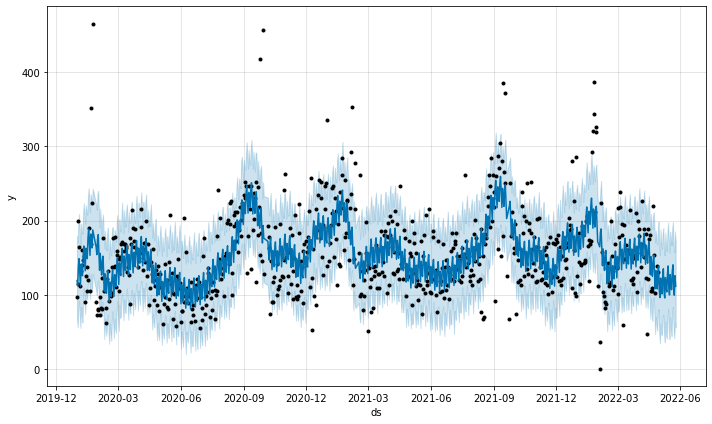

In [ ]:
prophet.plot(forecast)
plt.show()

In [ ]:
plot_plotly(prophet, forecast)

In [ ]:
print(len(forecast), len(train), len(df4))

740 714 741


In [ ]:
y_true = test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values
mae = mean_absolute_error(y_true, y_pred)
print('mae: %.3f' % mae)

mae: 32.030


In [ ]:
len(y_true), len(y_pred)

(27, 27)

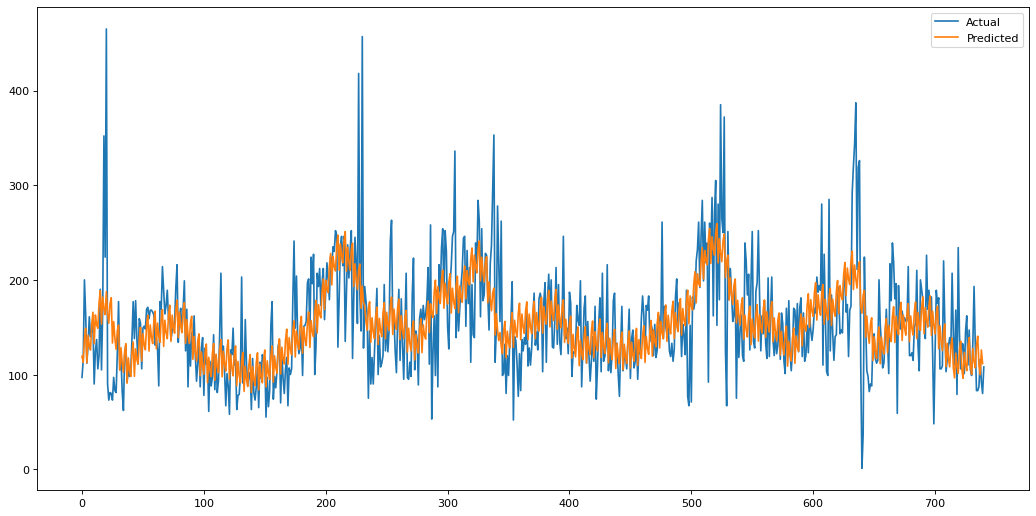

In [ ]:
from matplotlib import figure
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(16,8), dpi=80)

pltt.plot(df4['y'].values, label='Actual')
pltt.plot(forecast['yhat'].values, label='Predicted')
pltt.legend()
pltt.show()           

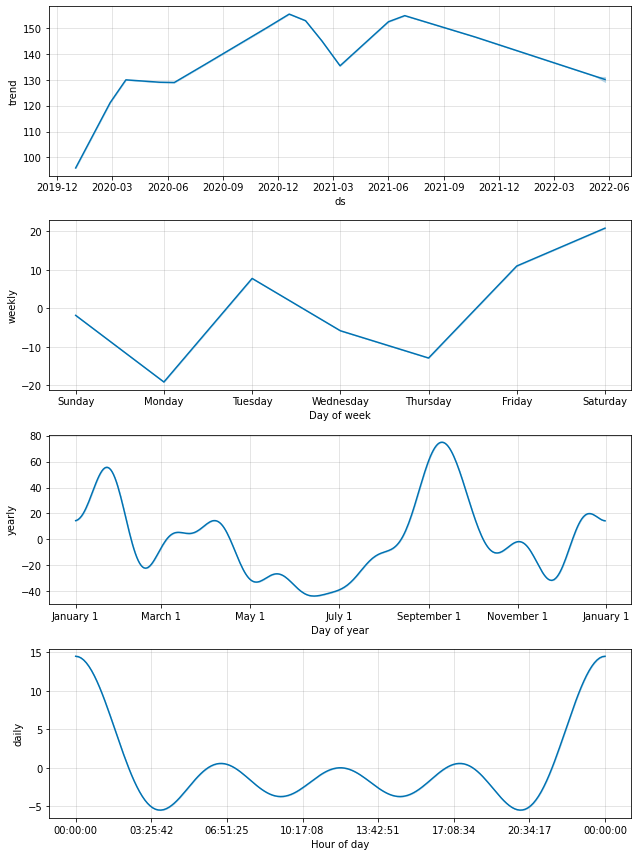

In [ ]:
fig2 = prophet.plot_components(forecast)
plt.show()

# skewness reduction

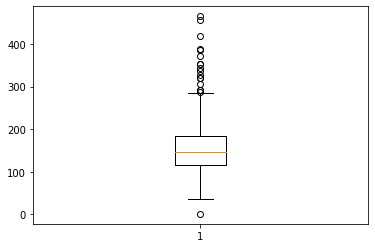

In [ ]:
df = df4.copy()
plt.boxplot(df.y.values)
plt.show()

In [ ]:
df['y'] = np.log(df['y'])

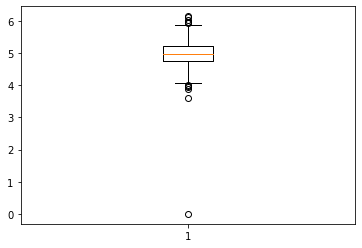

In [ ]:
plt.boxplot(df.y.values)
plt.show()

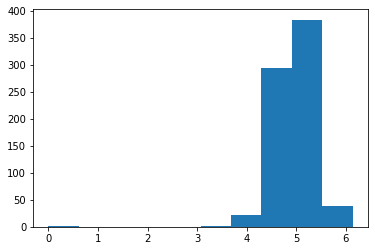

In [ ]:
plt.hist(df.y)
plt.show()

# outliers detection

In [ ]:
Q1 = df.y.quantile(0.25)
Q3 = df.y.quantile(0.75)
IQR = Q3 - Q1
LT = Q1 - 1.5*IQR
HT = Q3 + 1.5*IQR
print(LT, HT)
df['outliers'] = np.where(((df['y']<LT)|(df['y']>HT)), 'yes', 'no')

4.048101091645993 5.906317189558678


In [ ]:
df['outliers'].value_counts()

no     729
yes     12
Name: outliers, dtype: int64

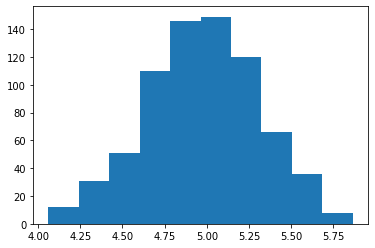

In [ ]:
plt.hist(df[df.outliers == 'no'].y)
plt.show()

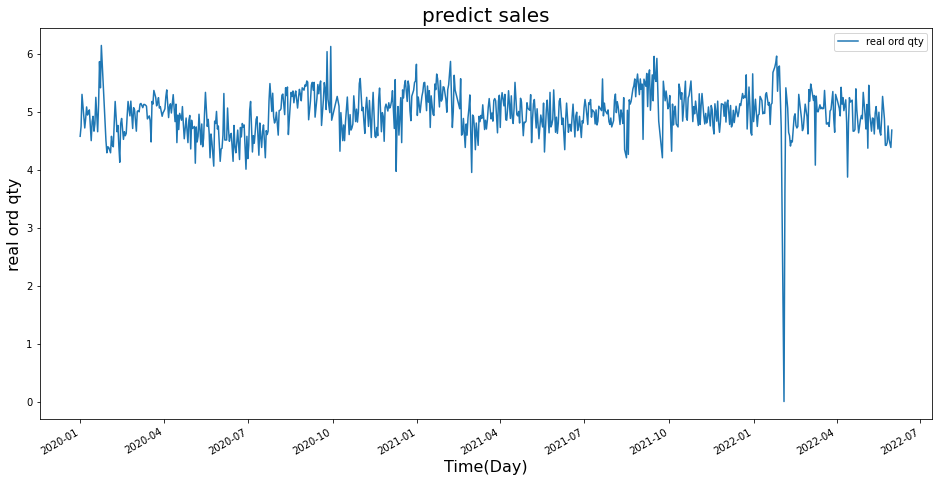

In [ ]:
_fig_plot(df, 'ds', 'y')

In [ ]:
df['SMA'] = df['y'].rolling(window=6).mean()
df['diff'] = df['y'] - df['SMA']
df

,ds,y,outliers,SMA,diff
0,2020-01-01,4.574711,no,NaN,NaN
1,2020-01-02,4.744932,no,NaN,NaN
2,2020-01-03,5.298317,no,NaN,NaN
3,2020-01-04,5.099866,no,NaN,NaN
4,2020-01-06,4.718499,no,NaN,NaN
...,...,...,...,...,...
736,2022-05-26,4.465908,no,4.721971,-0.256063
737,2022-05-27,4.753590,no,4.699178,0.054412
738,2022-05-28,4.521789,no,4.575694,-0.053906
739,2022-05-30,4.382027,no,4.493499,-0.111472


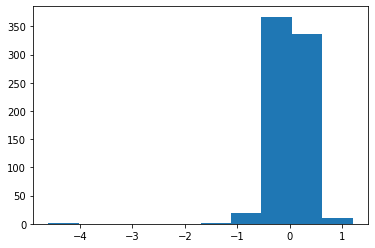

In [ ]:
plt.hist(df['diff'])
plt.show()

# outlier treatment

In [ ]:
df.loc[(df['outliers']=='yes'), 'y'] = None
df

,ds,y,outliers,SMA,diff
0,2020-01-01,4.574711,no,NaN,NaN
1,2020-01-02,4.744932,no,NaN,NaN
2,2020-01-03,5.298317,no,NaN,NaN
3,2020-01-04,5.099866,no,NaN,NaN
4,2020-01-06,4.718499,no,NaN,NaN
...,...,...,...,...,...
736,2022-05-26,4.465908,no,4.721971,-0.256063
737,2022-05-27,4.753590,no,4.699178,0.054412
738,2022-05-28,4.521789,no,4.575694,-0.053906
739,2022-05-30,4.382027,no,4.493499,-0.111472


In [ ]:
df['y'].isna().sum()

12

In [ ]:
df.dropna()
df.y.fillna(df.y.mean())

0      4.574711
1      4.744932
2      5.298317
3      5.099866
4      4.718499
         ...   
736    4.465908
737    4.753590
738    4.521789
739    4.382027
740    4.682131
Name: y, Length: 741, dtype: float64

# performance comparison

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6b3xxt3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/pkg14_9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50631', 'data', 'file=/tmp/tmpn53kg2pj/6b3xxt3v.json', 'init=/tmp/tmpn53kg2pj/pkg14_9u.json', 'output', 'file=/tmp/tmprp9w581a/prophet_model-20220803050329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:03:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:03:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


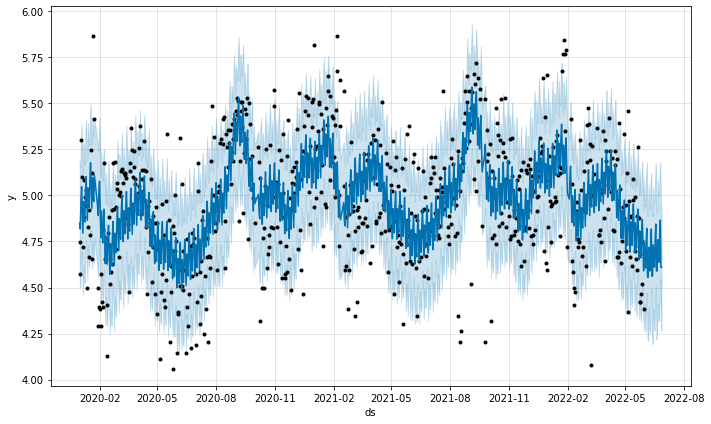

In [ ]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=27)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

In [ ]:
evaluation_model = cross_validation(m, initial='714 days', period='26 days', horizon = '30 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

INFO:prophet:Making 6 forecasts with cutoffs between 2021-12-22 00:00:00 and 2022-05-01 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/0xlslk_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/h1pgsr3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32000', 'data', 'file=/tmp/tmpn53kg2pj/0xlslk_u.json', 'init=/tmp/tmpn53kg2pj/h1pgsr3n.json', 'output', 'file=/tmp/tmp1l9of83m/prophet_model-20220803050337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/s367ursd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/kh8g8gq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.079353,0.281697,0.224340,0.044757,0.040576,0.044491,0.671429
1,4 days,0.075368,0.274533,0.213030,0.043455,0.038389,0.042799,0.761905
2,5 days,0.096743,0.311035,0.234405,0.046014,0.042124,0.046261,0.671429
3,6 days,0.068456,0.261642,0.201611,0.038913,0.032309,0.039534,0.785714
4,7 days,0.130275,0.360936,0.282993,0.054143,0.044662,0.054948,0.614286


# Performance with Base Prophet

In [ ]:
df_train = df[df['ds'] < '2022-05-01'] 
df_test = df[df['ds'] >= '2022-05-01']

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/w0qj179_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xklju4sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82203', 'data', 'file=/tmp/tmpn53kg2pj/w0qj179_.json', 'init=/tmp/tmpn53kg2pj/xklju4sf.json', 'output', 'file=/tmp/tmpmn92dgxz/prophet_model-20220803050355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:03:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


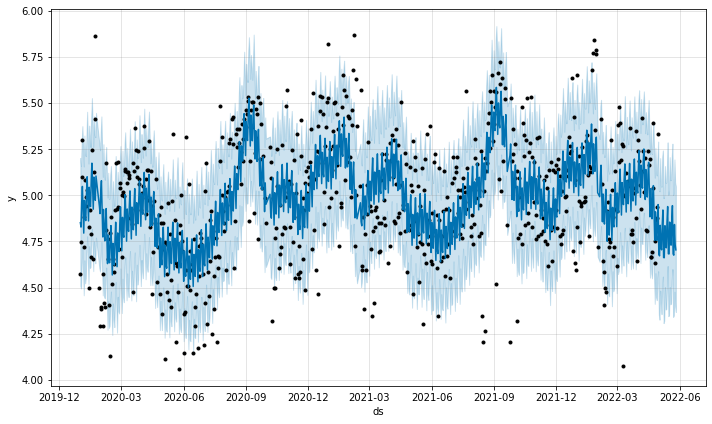

In [ ]:
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=26)
forecast_tr = m.predict(future)
m.plot(forecast_tr)
plt.show()

In [ ]:
forecast_test = m.predict(df_test[['ds']])

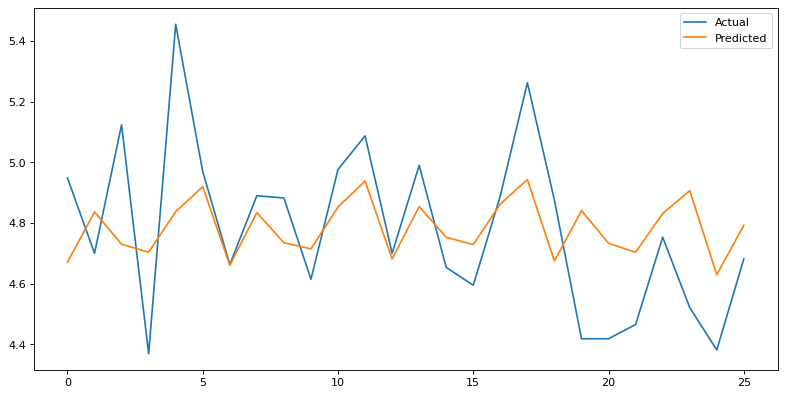

In [ ]:
forecast_test = m.predict(df_test[['ds']])
from matplotlib.pyplot import figure 
figure(figsize=(12, 6), dpi=80)
plt.plot(df_test['y'].values, label='Actual')
plt.plot(forecast_test['yhat'].values, label='Predicted')
plt.legend()
plt.show()

In [ ]:
evaluation_model = cross_validation(m, initial='714 days', period='26 days', horizon = '30 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

INFO:prophet:Making 5 forecasts with cutoffs between 2021-12-17 00:00:00 and 2022-03-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/5kxj6f2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/30j5s4_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80020', 'data', 'file=/tmp/tmpn53kg2pj/5kxj6f2z.json', 'init=/tmp/tmpn53kg2pj/30j5s4_j.json', 'output', 'file=/tmp/tmp53yhm867/prophet_model-20220803050413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:04:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_oozwmlw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/8ikvtz0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.082551,0.287318,0.233980,0.048334,0.034968,0.047248,0.750000
1,4 days,0.156891,0.396095,0.293528,0.064269,0.044963,0.061132,0.666667
2,5 days,0.175879,0.419379,0.318220,0.069649,0.052809,0.066036,0.687500
3,6 days,0.138233,0.371797,0.271894,0.058121,0.023124,0.055647,0.708333
4,7 days,0.070657,0.265815,0.217066,0.042886,0.023124,0.042605,0.700000


# add holidays

In [ ]:
import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2020, 2021, 2022]).items()):
  holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday':'US-Holidays'}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%s', errors='ignore')

In [ ]:
holiday

,ds,holiday
0,2020-01-01,US-Holidays
1,2020-01-20,US-Holidays
2,2020-02-17,US-Holidays
3,2020-05-25,US-Holidays
4,2020-07-03,US-Holidays
5,2020-07-04,US-Holidays
6,2020-09-07,US-Holidays
7,2020-10-12,US-Holidays
8,2020-11-11,US-Holidays
9,2020-11-26,US-Holidays


# change partition size

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/c1p0ojov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/bwof2deg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44877', 'data', 'file=/tmp/tmpn53kg2pj/c1p0ojov.json', 'init=/tmp/tmpn53kg2pj/bwof2deg.json', 'output', 'file=/tmp/tmprn26tato/prophet_model-20220803054123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


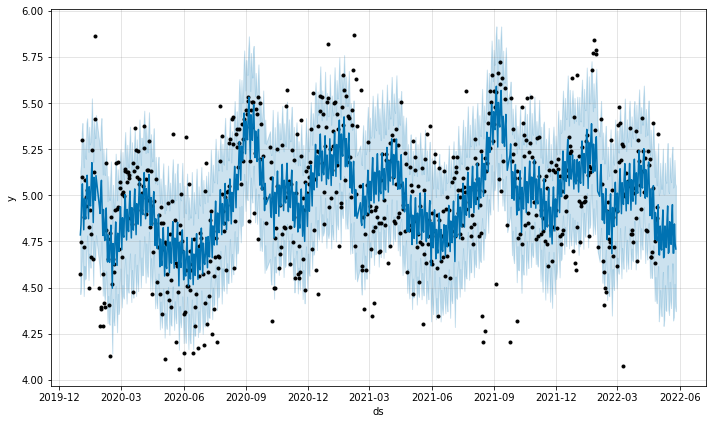

In [ ]:
m2 = Prophet(holidays=holiday)
m2.fit(df_train)

future = m2.make_future_dataframe(periods=26)
forecast_tr = m2.predict(future)
m2.plot(forecast_tr)
plt.show()

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {#'weekly_seasonality':('multiplicative', 'additive'),
               'seasonality_mode':('multiplicative', 'additive'),
               'changepoint_prior_scale':[0.1, 0.2, 0.3, 0.4, 0.5],
               'holidays_prior_scale':[0.1, 0.2, 0.3, 0.4, 0.5],
               'n_changepoints':[100, 150, 200]}

grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
  cnt += 1

print('total possible models: ', cnt)


total possible models:  150


In [ ]:
print('Traing data, last data: ' + str(df_train.tail(1)['ds']) + ' ' + 'testing data, last data: ' + str(df_test.tail(1)['ds']))

Traing data, last data: 714   2022-04-30
Name: ds, dtype: datetime64[ns] testing data, last data: 740   2022-05-31
Name: ds, dtype: datetime64[ns]


In [ ]:
dummy = ['outliers', 'SMA', 'diff']

df_train.drop(dummy, axis=1, inplace=True)
df_test.drop(dummy, axis=1, inplace=True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      715 non-null    datetime64[ns]
 1   y       703 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.8 KB


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      715 non-null    object
 1   y       715 non-null    object
dtypes: object(2)
memory usage: 16.8+ KB


In [ ]:
df_train['y'].fillna('ffill', inplace=True)

In [ ]:
start = '2022-04-30'
end = '2020-05-31'

from random import *
model_parameters = pd.DataFrame(columns = ['MAE', 'Parameters'])
for p in grid:
  LOL = pd.DataFrame()
  print(p)

  train_model = Prophet(changepoint_prior_scale= p['changepoint_prior_scale'],
                        holidays_prior_scale= p['holidays_prior_scale'],
                        n_changepoints = p['n_changepoints'],
                        seasonality_mode= p['seasonality_mode'],
                        #weekly_seasonality= p['weekly_seasonality'],
                        daily_seasonality=True,
                        yearly_seasonality = True,
                        holidays=holiday,
                        interval_width=0.95)
  
  train_model.add_country_holidays(country_name='US')
  train_model.fit(df)
  train_forecast = train_model.make_future_dataframe(periods=26, freq='D', include_history=False)
  train_forecast = train_model.predict(train_forecast)
  LOL = train_forecast[['ds','yhat']]
  y_true = df_test['y'].values
  y_pred = LOL['yhat'][:len(y_true)].values
  mae = mean_absolute_error(y_true, y_pred)
  print('MAE: %.3f' % mae)
  model_parameters = model_parameters.append({'MAE':mae, 'Parameters':p}, ignore_index=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/e_wpj6v5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/kfcv71yp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61929', 'data', 'file=/tmp/tmpn53kg2pj/e_wpj6v5.json', 'init=/tmp/tmpn53kg2pj/kfcv71yp.json', 'output', 'file=/tmp/tmpgylmi2rv/prophet_model-20220803060912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:09:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/m2ft8ac2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/nmkbmg6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13935', 'data', 'file=/tmp/tmpn53kg2pj/m2ft8ac2.json', 'init=/tmp/tmpn53kg2pj/nmkbmg6u.json', 'output', 'file=/tmp/tmpunodqo1b/prophet_model-20220803060914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.242
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:09:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6utqw7mj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/k_111h0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51890', 'data', 'file=/tmp/tmpn53kg2pj/6utqw7mj.json', 'init=/tmp/tmpn53kg2pj/k_111h0i.json', 'output', 'file=/tmp/tmp98r67g7d/prophet_model-20220803060917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.245
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:09:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/1ajijyue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_hmwzotv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97841', 'data', 'file=/tmp/tmpn53kg2pj/1ajijyue.json', 'init=/tmp/tmpn53kg2pj/_hmwzotv.json', 'output', 'file=/tmp/tmp7pnmo6mg/prophet_model-20220803060920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.241
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:09:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/z7pk1w94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/r0em9jsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93923', 'data', 'file=/tmp/tmpn53kg2pj/z7pk1w94.json', 'init=/tmp/tmpn53kg2pj/r0em9jsp.json', 'output', 'file=/tmp/tmpcrso2f8_/prophet_model-20220803060923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:09:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/43dt4g6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/x8dfu9sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75674', 'data', 'file=/tmp/tmpn53kg2pj/43dt4g6t.json', 'init=/tmp/tmpn53kg2pj/x8dfu9sa.json', 'output', 'file=/tmp/tmpn_i7xirg/prophet_model-20220803060928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.240
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:09:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xu3uh0nv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/j0ce3qsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74158', 'data', 'file=/tmp/tmpn53kg2pj/xu3uh0nv.json', 'init=/tmp/tmpn53kg2pj/j0ce3qsn.json', 'output', 'file=/tmp/tmp3187zja0/prophet_model-20220803060932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.245
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:09:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/lu5qipwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/tvkmim02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86111', 'data', 'file=/tmp/tmpn53kg2pj/lu5qipwv.json', 'init=/tmp/tmpn53kg2pj/tvkmim02.json', 'output', 'file=/tmp/tmpqet5wlkj/prophet_model-20220803060934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:09:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/o141edw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/9gwa4wyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69334', 'data', 'file=/tmp/tmpn53kg2pj/o141edw6.json', 'init=/tmp/tmpn53kg2pj/9gwa4wyc.json', 'output', 'file=/tmp/tmpw_yng7no/prophet_model-20220803060937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:09:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/x36btu3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/c2wv4tcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44512', 'data', 'file=/tmp/tmpn53kg2pj/x36btu3j.json', 'init=/tmp/tmpn53kg2pj/c2wv4tcc.json', 'output', 'file=/tmp/tmppe8ib8ni/prophet_model-20220803060941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.242
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:09:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/s__s0_98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/dgkyzl3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14848', 'data', 'file=/tmp/tmpn53kg2pj/s__s0_98.json', 'init=/tmp/tmpn53kg2pj/dgkyzl3s.json', 'output', 'file=/tmp/tmpk_wz1n0x/prophet_model-20220803060944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:09:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/i1p21cio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/918zj20j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67376', 'data', 'file=/tmp/tmpn53kg2pj/i1p21cio.json', 'init=/tmp/tmpn53kg2pj/918zj20j.json', 'output', 'file=/tmp/tmp8f9xq51y/prophet_model-20220803060948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.242
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_xfjbn_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/y0xv9_f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99999', 'data', 'file=/tmp/tmpn53kg2pj/_xfjbn_l.json', 'init=/tmp/tmpn53kg2pj/y0xv9_f2.json', 'output', 'file=/tmp/tmpxsejc6so/prophet_model-20220803060952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.245
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:09:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/qe6vusko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/1jlu_ro3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9422', 'data', 'file=/tmp/tmpn53kg2pj/qe6vusko.json', 'init=/tmp/tmpn53kg2pj/1jlu_ro3.json', 'output', 'file=/tmp/tmp7o17b0op/prophet_model-20220803060955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:09:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2_6v422u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/w403lsmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97394', 'data', 'file=/tmp/tmpn53kg2pj/2_6v422u.json', 'init=/tmp/tmpn53kg2pj/w403lsmx.json', 'output', 'file=/tmp/tmpy1jpau5l/prophet_model-20220803060957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:09:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/neglec5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_cx5n3cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79663', 'data', 'file=/tmp/tmpn53kg2pj/neglec5c.json', 'init=/tmp/tmpn53kg2pj/_cx5n3cp.json', 'output', 'file=/tmp/tmpk7tn5t0h/prophet_model-20220803061001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.242
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:10:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/x7kn6kyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/pbowrhsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92363', 'data', 'file=/tmp/tmpn53kg2pj/x7kn6kyh.json', 'init=/tmp/tmpn53kg2pj/pbowrhsk.json', 'output', 'file=/tmp/tmph42582vv/prophet_model-20220803061004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:10:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/wnh5ntxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7f7ownxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46424', 'data', 'file=/tmp/tmpn53kg2pj/wnh5ntxw.json', 'init=/tmp/tmpn53kg2pj/7f7ownxa.json', 'output', 'file=/tmp/tmp_celblmj/prophet_model-20220803061008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:10:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/keyh_jfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/to3y_sx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34711', 'data', 'file=/tmp/tmpn53kg2pj/keyh_jfg.json', 'init=/tmp/tmpn53kg2pj/to3y_sx8.json', 'output', 'file=/tmp/tmpmbw5fb9s/prophet_model-20220803061012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:10:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/jgrfd7qs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/mqq008k4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69095', 'data', 'file=/tmp/tmpn53kg2pj/jgrfd7qs.json', 'init=/tmp/tmpn53kg2pj/mqq008k4.json', 'output', 'file=/tmp/tmp9mofim11/prophet_model-20220803061015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:10:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/8ck0tfcl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/8reu4nv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63748', 'data', 'file=/tmp/tmpn53kg2pj/8ck0tfcl.json', 'init=/tmp/tmpn53kg2pj/8reu4nv1.json', 'output', 'file=/tmp/tmp80k_cqdr/prophet_model-20220803061017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:10:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/s2bhiabm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/dhxjfvad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66136', 'data', 'file=/tmp/tmpn53kg2pj/s2bhiabm.json', 'init=/tmp/tmpn53kg2pj/dhxjfvad.json', 'output', 'file=/tmp/tmpos5q8sj_/prophet_model-20220803061020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:10:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/yx8zsk_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_nc9cclr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45746', 'data', 'file=/tmp/tmpn53kg2pj/yx8zsk_j.json', 'init=/tmp/tmpn53kg2pj/_nc9cclr.json', 'output', 'file=/tmp/tmp_3omkers/prophet_model-20220803061024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:10:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6uwt8w83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/lw7higll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95639', 'data', 'file=/tmp/tmpn53kg2pj/6uwt8w83.json', 'init=/tmp/tmpn53kg2pj/lw7higll.json', 'output', 'file=/tmp/tmpbvynhgvg/prophet_model-20220803061028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.242
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:10:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ru9i6_ld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/foni8inl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81678', 'data', 'file=/tmp/tmpn53kg2pj/ru9i6_ld.json', 'init=/tmp/tmpn53kg2pj/foni8inl.json', 'output', 'file=/tmp/tmpvzhp2w89/prophet_model-20220803061032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:10:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6hfbr98j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/z8klokce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11692', 'data', 'file=/tmp/tmpn53kg2pj/6hfbr98j.json', 'init=/tmp/tmpn53kg2pj/z8klokce.json', 'output', 'file=/tmp/tmp20xnjagp/prophet_model-20220803061034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:10:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/8djx7vwx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/zgy7lbci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2783', 'data', 'file=/tmp/tmpn53kg2pj/8djx7vwx.json', 'init=/tmp/tmpn53kg2pj/zgy7lbci.json', 'output', 'file=/tmp/tmpyyjqdiqv/prophet_model-20220803061037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:10:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/c63togey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/vjddgjgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82039', 'data', 'file=/tmp/tmpn53kg2pj/c63togey.json', 'init=/tmp/tmpn53kg2pj/vjddgjgl.json', 'output', 'file=/tmp/tmphkj43y4x/prophet_model-20220803061041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6h3kaxdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/lpaapzt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54945', 'data', 'file=/tmp/tmpn53kg2pj/6h3kaxdh.json', 'init=/tmp/tmpn53kg2pj/lpaapzt9.json', 'output', 'file=/tmp/tmpv1a3ls9o/prophet_model-20220803061044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:10:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/phy8t9ns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4ztf6p1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33832', 'data', 'file=/tmp/tmpn53kg2pj/phy8t9ns.json', 'init=/tmp/tmpn53kg2pj/4ztf6p1v.json', 'output', 'file=/tmp/tmpxz1grzf4/prophet_model-20220803061048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.243
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7ul4_cma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/z3h6y219.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36605', 'data', 'file=/tmp/tmpn53kg2pj/7ul4_cma.json', 'init=/tmp/tmpn53kg2pj/z3h6y219.json', 'output', 'file=/tmp/tmpbh5a6t2f/prophet_model-20220803061052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.244
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:10:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xcx1tfwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/13prybya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39008', 'data', 'file=/tmp/tmpn53kg2pj/xcx1tfwm.json', 'init=/tmp/tmpn53kg2pj/13prybya.json', 'output', 'file=/tmp/tmpq_v28jmm/prophet_model-20220803061058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.357
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:10:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ebmm0rjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_2mw0q4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51483', 'data', 'file=/tmp/tmpn53kg2pj/ebmm0rjo.json', 'init=/tmp/tmpn53kg2pj/_2mw0q4a.json', 'output', 'file=/tmp/tmppx1beh73/prophet_model-20220803061101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:11:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2ee7hli0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/hs0d0dos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71380', 'data', 'file=/tmp/tmpn53kg2pj/2ee7hli0.json', 'init=/tmp/tmpn53kg2pj/hs0d0dos.json', 'output', 'file=/tmp/tmp2z2ktlzz/prophet_model-20220803061108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.348
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:11:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/5_88x31t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4ot5a94h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97317', 'data', 'file=/tmp/tmpn53kg2pj/5_88x31t.json', 'init=/tmp/tmpn53kg2pj/4ot5a94h.json', 'output', 'file=/tmp/tmpczcngpcu/prophet_model-20220803061112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.251
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:11:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/pysthlyk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/s49nnjfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23683', 'data', 'file=/tmp/tmpn53kg2pj/pysthlyk.json', 'init=/tmp/tmpn53kg2pj/s49nnjfh.json', 'output', 'file=/tmp/tmpvoskngfq/prophet_model-20220803061118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.264
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:11:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/cbgrqpl9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/1_5yivsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20914', 'data', 'file=/tmp/tmpn53kg2pj/cbgrqpl9.json', 'init=/tmp/tmpn53kg2pj/1_5yivsf.json', 'output', 'file=/tmp/tmp28ngj2em/prophet_model-20220803061122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.252
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:11:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/f6cdfod1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/b7zp532i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31017', 'data', 'file=/tmp/tmpn53kg2pj/f6cdfod1.json', 'init=/tmp/tmpn53kg2pj/b7zp532i.json', 'output', 'file=/tmp/tmpc69xk_j2/prophet_model-20220803061127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.351
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:11:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ls6_1j66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/afc0ybfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87006', 'data', 'file=/tmp/tmpn53kg2pj/ls6_1j66.json', 'init=/tmp/tmpn53kg2pj/afc0ybfi.json', 'output', 'file=/tmp/tmpzkgnkvql/prophet_model-20220803061130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:11:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/53y92oft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/957gxylh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74937', 'data', 'file=/tmp/tmpn53kg2pj/53y92oft.json', 'init=/tmp/tmpn53kg2pj/957gxylh.json', 'output', 'file=/tmp/tmp7oo55orm/prophet_model-20220803061138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.346
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:11:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_7xm3xk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/uhi7xb8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69772', 'data', 'file=/tmp/tmpn53kg2pj/_7xm3xk6.json', 'init=/tmp/tmpn53kg2pj/uhi7xb8_.json', 'output', 'file=/tmp/tmpna2o8gxs/prophet_model-20220803061141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.251
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:11:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ag0dfs_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2gxyb8ce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15937', 'data', 'file=/tmp/tmpn53kg2pj/ag0dfs_0.json', 'init=/tmp/tmpn53kg2pj/2gxyb8ce.json', 'output', 'file=/tmp/tmpwgq8pa86/prophet_model-20220803061149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.339
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:11:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/0mpz9kme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/9f01ga57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23942', 'data', 'file=/tmp/tmpn53kg2pj/0mpz9kme.json', 'init=/tmp/tmpn53kg2pj/9f01ga57.json', 'output', 'file=/tmp/tmp0yb_8uuy/prophet_model-20220803061154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:11:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ckm7fwb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/zbbh33hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22195', 'data', 'file=/tmp/tmpn53kg2pj/ckm7fwb3.json', 'init=/tmp/tmpn53kg2pj/zbbh33hd.json', 'output', 'file=/tmp/tmpcfxof6po/prophet_model-20220803061159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:11:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.351
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:11:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/vsa1u87s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/bw9twt65.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18582', 'data', 'file=/tmp/tmpn53kg2pj/vsa1u87s.json', 'init=/tmp/tmpn53kg2pj/bw9twt65.json', 'output', 'file=/tmp/tmpas9y14bd/prophet_model-20220803061202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:12:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/nlx4ko7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/592vh8sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75938', 'data', 'file=/tmp/tmpn53kg2pj/nlx4ko7z.json', 'init=/tmp/tmpn53kg2pj/592vh8sf.json', 'output', 'file=/tmp/tmpdwh73adi/prophet_model-20220803061208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.343
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/d061lgq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/gzz709tm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87597', 'data', 'file=/tmp/tmpn53kg2pj/d061lgq_.json', 'init=/tmp/tmpn53kg2pj/gzz709tm.json', 'output', 'file=/tmp/tmpv_cmxyd0/prophet_model-20220803061212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:12:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/knkbz0ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/0hnol8nw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15818', 'data', 'file=/tmp/tmpn53kg2pj/knkbz0ou.json', 'init=/tmp/tmpn53kg2pj/0hnol8nw.json', 'output', 'file=/tmp/tmp9f4q75xs/prophet_model-20220803061220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.344
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:12:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/uuvun0ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/vfanzj1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55061', 'data', 'file=/tmp/tmpn53kg2pj/uuvun0ct.json', 'init=/tmp/tmpn53kg2pj/vfanzj1w.json', 'output', 'file=/tmp/tmphqrpd13d/prophet_model-20220803061224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:12:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/pc8rt7io.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4z_dy08i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97421', 'data', 'file=/tmp/tmpn53kg2pj/pc8rt7io.json', 'init=/tmp/tmpn53kg2pj/4z_dy08i.json', 'output', 'file=/tmp/tmpicn94bjy/prophet_model-20220803061229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.351
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/iis0hblp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/nw8raaqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65862', 'data', 'file=/tmp/tmpn53kg2pj/iis0hblp.json', 'init=/tmp/tmpn53kg2pj/nw8raaqd.json', 'output', 'file=/tmp/tmph98t3qwz/prophet_model-20220803061232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:12:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/l3t3v8vv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/umkdv_at.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37819', 'data', 'file=/tmp/tmpn53kg2pj/l3t3v8vv.json', 'init=/tmp/tmpn53kg2pj/umkdv_at.json', 'output', 'file=/tmp/tmpoac40d1c/prophet_model-20220803061238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.343
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6tp6pnn7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/nmkz06ku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10598', 'data', 'file=/tmp/tmpn53kg2pj/6tp6pnn7.json', 'init=/tmp/tmpn53kg2pj/nmkz06ku.json', 'output', 'file=/tmp/tmp2o4j_vap/prophet_model-20220803061242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/qj2fzps4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/25dmaor2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84610', 'data', 'file=/tmp/tmpn53kg2pj/qj2fzps4.json', 'init=/tmp/tmpn53kg2pj/25dmaor2.json', 'output', 'file=/tmp/tmpi4q59cww/prophet_model-20220803061251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.347
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/voo2svvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2lja4zy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10176', 'data', 'file=/tmp/tmpn53kg2pj/voo2svvq.json', 'init=/tmp/tmpn53kg2pj/2lja4zy5.json', 'output', 'file=/tmp/tmp1l2i8e3s/prophet_model-20220803061256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/b9kvzz8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xoq47q8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28929', 'data', 'file=/tmp/tmpn53kg2pj/b9kvzz8z.json', 'init=/tmp/tmpn53kg2pj/xoq47q8d.json', 'output', 'file=/tmp/tmpnkxadh4v/prophet_model-20220803061300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.350
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2gt64umz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2qr2fw8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58373', 'data', 'file=/tmp/tmpn53kg2pj/2gt64umz.json', 'init=/tmp/tmpn53kg2pj/2qr2fw8h.json', 'output', 'file=/tmp/tmp8cypkvy9/prophet_model-20220803061303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.347
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/j5ad46xz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/fmwcpryw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36053', 'data', 'file=/tmp/tmpn53kg2pj/j5ad46xz.json', 'init=/tmp/tmpn53kg2pj/fmwcpryw.json', 'output', 'file=/tmp/tmpukamea06/prophet_model-20220803061311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/siuuci1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/1jo9j9eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

MAE: 0.250
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:13:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/hoxszip5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4es0oeu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15527', 'data', 'file=/tmp/tmpn53kg2pj/hoxszip5.json', 'init=/tmp/tmpn53kg2pj/4es0oeu6.json', 'output', 'file=/tmp/tmpsdkvxxw5/prophet_model-20220803061325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.350
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:13:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ycx8mkfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6_awango.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22103', 'data', 'file=/tmp/tmpn53kg2pj/ycx8mkfa.json', 'init=/tmp/tmpn53kg2pj/6_awango.json', 'output', 'file=/tmp/tmpr1nsr7tu/prophet_model-20220803061330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.251
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:13:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ar865wpc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/msq5eu6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80933', 'data', 'file=/tmp/tmpn53kg2pj/ar865wpc.json', 'init=/tmp/tmpn53kg2pj/msq5eu6v.json', 'output', 'file=/tmp/tmpkfzoasv0/prophet_model-20220803061334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.355
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:13:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2meric8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/o_y3ldf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19721', 'data', 'file=/tmp/tmpn53kg2pj/2meric8a.json', 'init=/tmp/tmpn53kg2pj/o_y3ldf6.json', 'output', 'file=/tmp/tmp2obst23v/prophet_model-20220803061337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:13:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/q1r3lhqi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7e19l_y3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74122', 'data', 'file=/tmp/tmpn53kg2pj/q1r3lhqi.json', 'init=/tmp/tmpn53kg2pj/7e19l_y3.json', 'output', 'file=/tmp/tmpx68a4f0q/prophet_model-20220803061345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.357
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:13:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/sb_zx8w8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7frtni_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9722', 'data', 'file=/tmp/tmpn53kg2pj/sb_zx8w8.json', 'init=/tmp/tmpn53kg2pj/7frtni_u.json', 'output', 'file=/tmp/tmpw_0k_oi7/prophet_model-20220803061349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:13:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/hp0tdjgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/com0ewep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34870', 'data', 'file=/tmp/tmpn53kg2pj/hp0tdjgs.json', 'init=/tmp/tmpn53kg2pj/com0ewep.json', 'output', 'file=/tmp/tmpbal1kgzs/prophet_model-20220803061357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.355
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:13:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/n2dixnkz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/w86dlrla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68413', 'data', 'file=/tmp/tmpn53kg2pj/n2dixnkz.json', 'init=/tmp/tmpn53kg2pj/w86dlrla.json', 'output', 'file=/tmp/tmpghgek29v/prophet_model-20220803061402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:14:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/m80mglo6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/mq4_890w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33385', 'data', 'file=/tmp/tmpn53kg2pj/m80mglo6.json', 'init=/tmp/tmpn53kg2pj/mq4_890w.json', 'output', 'file=/tmp/tmpblot2ew2/prophet_model-20220803061408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.353
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:14:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/iqf9054t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_hm3sykr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80519', 'data', 'file=/tmp/tmpn53kg2pj/iqf9054t.json', 'init=/tmp/tmpn53kg2pj/_hm3sykr.json', 'output', 'file=/tmp/tmp71vlundd/prophet_model-20220803061411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.248
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:14:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/vw8h1o2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/9s73zyx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11365', 'data', 'file=/tmp/tmpn53kg2pj/vw8h1o2g.json', 'init=/tmp/tmpn53kg2pj/9s73zyx7.json', 'output', 'file=/tmp/tmp9py0nc7e/prophet_model-20220803061417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.347
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:14:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/mep1fxj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/07d_491x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44236', 'data', 'file=/tmp/tmpn53kg2pj/mep1fxj8.json', 'init=/tmp/tmpn53kg2pj/07d_491x.json', 'output', 'file=/tmp/tmphrr75g2u/prophet_model-20220803061421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/trglad6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/af9khgdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18607', 'data', 'file=/tmp/tmpn53kg2pj/trglad6g.json', 'init=/tmp/tmpn53kg2pj/af9khgdt.json', 'output', 'file=/tmp/tmppbw0tkfs/prophet_model-20220803061431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.350
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/3w2id683.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/tvx7_l18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42128', 'data', 'file=/tmp/tmpn53kg2pj/3w2id683.json', 'init=/tmp/tmpn53kg2pj/tvx7_l18.json', 'output', 'file=/tmp/tmpqqfmfy0q/prophet_model-20220803061435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/0f5gq1q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/v43y5drl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92409', 'data', 'file=/tmp/tmpn53kg2pj/0f5gq1q2.json', 'init=/tmp/tmpn53kg2pj/v43y5drl.json', 'output', 'file=/tmp/tmpjvucbgda/prophet_model-20220803061441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.355
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/a91fqjb4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xoak30ub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60462', 'data', 'file=/tmp/tmpn53kg2pj/a91fqjb4.json', 'init=/tmp/tmpn53kg2pj/xoak30ub.json', 'output', 'file=/tmp/tmpehaycxeh/prophet_model-20220803061444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.248
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:14:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/0biqvmhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/981vpxjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78996', 'data', 'file=/tmp/tmpn53kg2pj/0biqvmhw.json', 'init=/tmp/tmpn53kg2pj/981vpxjo.json', 'output', 'file=/tmp/tmpp3z7z85j/prophet_model-20220803061452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.352
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/eu39om2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/myy9h1gu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4533', 'data', 'file=/tmp/tmpn53kg2pj/eu39om2r.json', 'init=/tmp/tmpn53kg2pj/myy9h1gu.json', 'output', 'file=/tmp/tmphle52as0/prophet_model-20220803061456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:15:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ivctuxm8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/eortfy7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63226', 'data', 'file=/tmp/tmpn53kg2pj/ivctuxm8.json', 'init=/tmp/tmpn53kg2pj/eortfy7j.json', 'output', 'file=/tmp/tmph3nid8ug/prophet_model-20220803061506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.350
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:15:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/t_iccf7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/eapm9wb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1873', 'data', 'file=/tmp/tmpn53kg2pj/t_iccf7s.json', 'init=/tmp/tmpn53kg2pj/eapm9wb4.json', 'output', 'file=/tmp/tmpql48mida/prophet_model-20220803061510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/edje_ebl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/utly27k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21754', 'data', 'file=/tmp/tmpn53kg2pj/edje_ebl.json', 'init=/tmp/tmpn53kg2pj/utly27k0.json', 'output', 'file=/tmp/tmpthmgazaj/prophet_model-20220803061518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.357
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/svsfhswk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xa17f60t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96297', 'data', 'file=/tmp/tmpn53kg2pj/svsfhswk.json', 'init=/tmp/tmpn53kg2pj/xa17f60t.json', 'output', 'file=/tmp/tmpjgprne0f/prophet_model-20220803061521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.248
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:15:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/n3afqup_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ihns71vg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48538', 'data', 'file=/tmp/tmpn53kg2pj/n3afqup_.json', 'init=/tmp/tmpn53kg2pj/ihns71vg.json', 'output', 'file=/tmp/tmpade1txy9/prophet_model-20220803061529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.353
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:15:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/zh9fq4h9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/v5e8k_ew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60270', 'data', 'file=/tmp/tmpn53kg2pj/zh9fq4h9.json', 'init=/tmp/tmpn53kg2pj/v5e8k_ew.json', 'output', 'file=/tmp/tmp8q00ijve/prophet_model-20220803061533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.248
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:15:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/fvaqb2hm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/3170zdey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=483', 'data', 'file=/tmp/tmpn53kg2pj/fvaqb2hm.json', 'init=/tmp/tmpn53kg2pj/3170zdey.json', 'output', 'file=/tmp/tmpk0dtksq3/prophet_model-20220803061543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.353
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:15:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/mz88bdag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/32a61fum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89232', 'data', 'file=/tmp/tmpn53kg2pj/mz88bdag.json', 'init=/tmp/tmpn53kg2pj/32a61fum.json', 'output', 'file=/tmp/tmpozsa7n88/prophet_model-20220803061548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:15:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6pai7cyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/m3b6t0kf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81546', 'data', 'file=/tmp/tmpn53kg2pj/6pai7cyo.json', 'init=/tmp/tmpn53kg2pj/m3b6t0kf.json', 'output', 'file=/tmp/tmpyprrtvtj/prophet_model-20220803061554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.359
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:15:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/3r4c2bn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/blfx49ud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44250', 'data', 'file=/tmp/tmpn53kg2pj/3r4c2bn9.json', 'init=/tmp/tmpn53kg2pj/blfx49ud.json', 'output', 'file=/tmp/tmp73dtr7vt/prophet_model-20220803061557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/nwdmjlrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/o6u_uk32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32360', 'data', 'file=/tmp/tmpn53kg2pj/nwdmjlrg.json', 'init=/tmp/tmpn53kg2pj/o6u_uk32.json', 'output', 'file=/tmp/tmp0vu_2few/prophet_model-20220803061606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.358
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:16:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/smee0jnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ginz7h9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19078', 'data', 'file=/tmp/tmpn53kg2pj/smee0jnf.json', 'init=/tmp/tmpn53kg2pj/ginz7h9u.json', 'output', 'file=/tmp/tmpalsnypib/prophet_model-20220803061610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:16:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6tc378fo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ehik5spc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82855', 'data', 'file=/tmp/tmpn53kg2pj/6tc378fo.json', 'init=/tmp/tmpn53kg2pj/ehik5spc.json', 'output', 'file=/tmp/tmp38r6f9mg/prophet_model-20220803061620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.352
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:16:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/uuz3mna6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/yyf_axiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6855', 'data', 'file=/tmp/tmpn53kg2pj/uuz3mna6.json', 'init=/tmp/tmpn53kg2pj/yyf_axiy.json', 'output', 'file=/tmp/tmpzdfegrb0/prophet_model-20220803061624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/zxnfik73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/rg8_i2dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58011', 'data', 'file=/tmp/tmpn53kg2pj/zxnfik73.json', 'init=/tmp/tmpn53kg2pj/rg8_i2dw.json', 'output', 'file=/tmp/tmp1rj_vrjj/prophet_model-20220803061630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.363
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:16:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ieog86kx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/jv4ldk3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51082', 'data', 'file=/tmp/tmpn53kg2pj/ieog86kx.json', 'init=/tmp/tmpn53kg2pj/jv4ldk3b.json', 'output', 'file=/tmp/tmpx53e6efh/prophet_model-20220803061633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.252
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:16:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/r392e3xm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ew5511vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90714', 'data', 'file=/tmp/tmpn53kg2pj/r392e3xm.json', 'init=/tmp/tmpn53kg2pj/ew5511vx.json', 'output', 'file=/tmp/tmps_vf97d8/prophet_model-20220803061641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.359
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/5sa9kiva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/bw42euab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14356', 'data', 'file=/tmp/tmpn53kg2pj/5sa9kiva.json', 'init=/tmp/tmpn53kg2pj/bw42euab.json', 'output', 'file=/tmp/tmpt2p_vete/prophet_model-20220803061646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:16:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/vol9_hqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/nv5sh0hg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11967', 'data', 'file=/tmp/tmpn53kg2pj/vol9_hqc.json', 'init=/tmp/tmpn53kg2pj/nv5sh0hg.json', 'output', 'file=/tmp/tmpmwfhg8it/prophet_model-20220803061656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.358
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:16:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7qw4p8b3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/szt6to_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90842', 'data', 'file=/tmp/tmpn53kg2pj/7qw4p8b3.json', 'init=/tmp/tmpn53kg2pj/szt6to_j.json', 'output', 'file=/tmp/tmpya36k82d/prophet_model-20220803061701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.251
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:17:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/3tr_7f8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ylpy4dxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86522', 'data', 'file=/tmp/tmpn53kg2pj/3tr_7f8e.json', 'init=/tmp/tmpn53kg2pj/ylpy4dxs.json', 'output', 'file=/tmp/tmprqsj7706/prophet_model-20220803061706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.359
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:17:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7_egdcpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/rh_cowv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64966', 'data', 'file=/tmp/tmpn53kg2pj/7_egdcpa.json', 'init=/tmp/tmpn53kg2pj/rh_cowv_.json', 'output', 'file=/tmp/tmpchrag_n_/prophet_model-20220803061710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.248
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:17:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/dr2vj6f9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/evu40nvq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44856', 'data', 'file=/tmp/tmpn53kg2pj/dr2vj6f9.json', 'init=/tmp/tmpn53kg2pj/evu40nvq.json', 'output', 'file=/tmp/tmpz5wdnt0b/prophet_model-20220803061718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.357
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:17:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/csxzlb4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_huw19s_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38221', 'data', 'file=/tmp/tmpn53kg2pj/csxzlb4j.json', 'init=/tmp/tmpn53kg2pj/_huw19s_.json', 'output', 'file=/tmp/tmp8dgw4l5n/prophet_model-20220803061724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:17:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/r011ar0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/kvkbc7o8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43952', 'data', 'file=/tmp/tmpn53kg2pj/r011ar0v.json', 'init=/tmp/tmpn53kg2pj/kvkbc7o8.json', 'output', 'file=/tmp/tmp9471iurx/prophet_model-20220803061734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.358
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:17:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_dyeobwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/59ant3r_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35589', 'data', 'file=/tmp/tmpn53kg2pj/_dyeobwv.json', 'init=/tmp/tmpn53kg2pj/59ant3r_.json', 'output', 'file=/tmp/tmp8bx7qo15/prophet_model-20220803061739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:17:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/sqfdm894.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7csg350o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66837', 'data', 'file=/tmp/tmpn53kg2pj/sqfdm894.json', 'init=/tmp/tmpn53kg2pj/7csg350o.json', 'output', 'file=/tmp/tmpnofo0bxs/prophet_model-20220803061744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.359
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/m45rysxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/e_rfh4n_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8692', 'data', 'file=/tmp/tmpn53kg2pj/m45rysxb.json', 'init=/tmp/tmpn53kg2pj/e_rfh4n_.json', 'output', 'file=/tmp/tmpz0rz3vmj/prophet_model-20220803061748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:17:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/57uc23em.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/d_cjw5kw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59805', 'data', 'file=/tmp/tmpn53kg2pj/57uc23em.json', 'init=/tmp/tmpn53kg2pj/d_cjw5kw.json', 'output', 'file=/tmp/tmp_38_vzxr/prophet_model-20220803061756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:17:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.362
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:17:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/dbc5schx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/18srtldb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67468', 'data', 'file=/tmp/tmpn53kg2pj/dbc5schx.json', 'init=/tmp/tmpn53kg2pj/18srtldb.json', 'output', 'file=/tmp/tmpi73cbs04/prophet_model-20220803061800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:18:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/8arq_0gi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/icmj07nc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75086', 'data', 'file=/tmp/tmpn53kg2pj/8arq_0gi.json', 'init=/tmp/tmpn53kg2pj/icmj07nc.json', 'output', 'file=/tmp/tmpc2qyf410/prophet_model-20220803061810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.360
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:18:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/63rs9_q4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4_emizh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15031', 'data', 'file=/tmp/tmpn53kg2pj/63rs9_q4.json', 'init=/tmp/tmpn53kg2pj/4_emizh8.json', 'output', 'file=/tmp/tmpmr6iuc4j/prophet_model-20220803061815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.251
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/yp9z8bs8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/fuj2ujd3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50954', 'data', 'file=/tmp/tmpn53kg2pj/yp9z8bs8.json', 'init=/tmp/tmpn53kg2pj/fuj2ujd3.json', 'output', 'file=/tmp/tmpaxdnph7d/prophet_model-20220803061819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.362
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4xglfmd7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ubx5svj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70419', 'data', 'file=/tmp/tmpn53kg2pj/4xglfmd7.json', 'init=/tmp/tmpn53kg2pj/ubx5svj2.json', 'output', 'file=/tmp/tmptaf_g8d3/prophet_model-20220803061823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:18:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/9rp4hxbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_96nrvmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59718', 'data', 'file=/tmp/tmpn53kg2pj/9rp4hxbq.json', 'init=/tmp/tmpn53kg2pj/_96nrvmn.json', 'output', 'file=/tmp/tmp6kgduhyz/prophet_model-20220803061831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.362
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:18:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/mb_2g8l_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xgrn19ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61041', 'data', 'file=/tmp/tmpn53kg2pj/mb_2g8l_.json', 'init=/tmp/tmpn53kg2pj/xgrn19ik.json', 'output', 'file=/tmp/tmpw4mia_am/prophet_model-20220803061835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.251
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.358
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/yeiqvjfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/3rd3v1n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31927', 'data', 'file=/tmp/tmpn53kg2pj/yeiqvjfd.json', 'init=/tmp/tmpn53kg2pj/3rd3v1n6.json', 'output', 'file=/tmp/tmp_jwjtsx1/prophet_model-20220803061845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:18:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/aycmfdr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ql9mxo5d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

MAE: 0.250
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/htyqyoma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/e25hcovo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77754', 'data', 'file=/tmp/tmpn53kg2pj/htyqyoma.json', 'init=/tmp/tmpn53kg2pj/e25hcovo.json', 'output', 'file=/tmp/tmpqubsijjs/prophet_model-20220803061855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.363
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:18:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/272zf_c0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_36l0646.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10933', 'data', 'file=/tmp/tmpn53kg2pj/272zf_c0.json', 'init=/tmp/tmpn53kg2pj/_36l0646.json', 'output', 'file=/tmp/tmp5pa8bqfi/prophet_model-20220803061858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.250
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/9rpec5nu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/_v1wtzza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79494', 'data', 'file=/tmp/tmpn53kg2pj/9rpec5nu.json', 'init=/tmp/tmpn53kg2pj/_v1wtzza.json', 'output', 'file=/tmp/tmpdnmy5f71/prophet_model-20220803061906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.368
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:19:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/pvdvodc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/b50sr1dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73715', 'data', 'file=/tmp/tmpn53kg2pj/pvdvodc2.json', 'init=/tmp/tmpn53kg2pj/b50sr1dw.json', 'output', 'file=/tmp/tmphp8ofip7/prophet_model-20220803061910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.251
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/7et76sge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/gcktlrrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51926', 'data', 'file=/tmp/tmpn53kg2pj/7et76sge.json', 'init=/tmp/tmpn53kg2pj/gcktlrrg.json', 'output', 'file=/tmp/tmp8cawkcz5/prophet_model-20220803061920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.361
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/n3zug0o7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/fav6j6g3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48118', 'data', 'file=/tmp/tmpn53kg2pj/n3zug0o7.json', 'init=/tmp/tmpn53kg2pj/fav6j6g3.json', 'output', 'file=/tmp/tmpjy5w74g2/prophet_model-20220803061926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.249
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/g07x99s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/wcbg2nqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29843', 'data', 'file=/tmp/tmpn53kg2pj/g07x99s2.json', 'init=/tmp/tmpn53kg2pj/wcbg2nqr.json', 'output', 'file=/tmp/tmpmwol07gh/prophet_model-20220803061932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.369
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/di1hi63k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/75zs3ymo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16960', 'data', 'file=/tmp/tmpn53kg2pj/di1hi63k.json', 'init=/tmp/tmpn53kg2pj/75zs3ymo.json', 'output', 'file=/tmp/tmpugb26byn/prophet_model-20220803061935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.254
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4dzs38zh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ln9py89g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44499', 'data', 'file=/tmp/tmpn53kg2pj/4dzs38zh.json', 'init=/tmp/tmpn53kg2pj/ln9py89g.json', 'output', 'file=/tmp/tmpiwtfio0g/prophet_model-20220803061943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.385
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/g24ncrds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/lnf0mknj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94807', 'data', 'file=/tmp/tmpn53kg2pj/g24ncrds.json', 'init=/tmp/tmpn53kg2pj/lnf0mknj.json', 'output', 'file=/tmp/tmpp7jzmn9r/prophet_model-20220803061948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.256
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/fbb5z7mm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/dinube6m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40211', 'data', 'file=/tmp/tmpn53kg2pj/fbb5z7mm.json', 'init=/tmp/tmpn53kg2pj/dinube6m.json', 'output', 'file=/tmp/tmpmyrqtcym/prophet_model-20220803061958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.361
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:20:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/u6n12vyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/rt4hysrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57078', 'data', 'file=/tmp/tmpn53kg2pj/u6n12vyr.json', 'init=/tmp/tmpn53kg2pj/rt4hysrd.json', 'output', 'file=/tmp/tmpdueeqgkp/prophet_model-20220803062004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.257
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:20:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/d8dvkmbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/zi5eje7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12747', 'data', 'file=/tmp/tmpn53kg2pj/d8dvkmbs.json', 'init=/tmp/tmpn53kg2pj/zi5eje7s.json', 'output', 'file=/tmp/tmp4dtf3yek/prophet_model-20220803062008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.355
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/43ziwcsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/noxpekwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24628', 'data', 'file=/tmp/tmpn53kg2pj/43ziwcsf.json', 'init=/tmp/tmpn53kg2pj/noxpekwp.json', 'output', 'file=/tmp/tmpt9tyk176/prophet_model-20220803062011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/jpl_th47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/f88n0h4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10376', 'data', 'file=/tmp/tmpn53kg2pj/jpl_th47.json', 'init=/tmp/tmpn53kg2pj/f88n0h4j.json', 'output', 'file=/tmp/tmpq2qiv4jl/prophet_model-20220803062020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.361
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/bikbgyc7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/kt9ck_4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86986', 'data', 'file=/tmp/tmpn53kg2pj/bikbgyc7.json', 'init=/tmp/tmpn53kg2pj/kt9ck_4q.json', 'output', 'file=/tmp/tmpt84lv217/prophet_model-20220803062024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.254
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/afsifrp_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/go6sffrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33849', 'data', 'file=/tmp/tmpn53kg2pj/afsifrp_.json', 'init=/tmp/tmpn53kg2pj/go6sffrw.json', 'output', 'file=/tmp/tmppu_mse4j/prophet_model-20220803062034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.360
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6vg5rgxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/tfjpfbyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11044', 'data', 'file=/tmp/tmpn53kg2pj/6vg5rgxh.json', 'init=/tmp/tmpn53kg2pj/tfjpfbyg.json', 'output', 'file=/tmp/tmphw96f5q0/prophet_model-20220803062039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.252
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2f11gazl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/0tf2lzf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8245', 'data', 'file=/tmp/tmpn53kg2pj/2f11gazl.json', 'init=/tmp/tmpn53kg2pj/0tf2lzf3.json', 'output', 'file=/tmp/tmpaxlibyxv/prophet_model-20220803062045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.374
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/yus5bvmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/roptofex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96279', 'data', 'file=/tmp/tmpn53kg2pj/yus5bvmn.json', 'init=/tmp/tmpn53kg2pj/roptofex.json', 'output', 'file=/tmp/tmp2bcfgcsj/prophet_model-20220803062049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:20:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4r_vsdd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/rgi2moqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86264', 'data', 'file=/tmp/tmpn53kg2pj/4r_vsdd1.json', 'init=/tmp/tmpn53kg2pj/rgi2moqz.json', 'output', 'file=/tmp/tmp40z1ltfz/prophet_model-20220803062056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.380
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/u6izdfq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/oza3ny_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31427', 'data', 'file=/tmp/tmpn53kg2pj/u6izdfq3.json', 'init=/tmp/tmpn53kg2pj/oza3ny_a.json', 'output', 'file=/tmp/tmp57i3tiyi/prophet_model-20220803062101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.255
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/rutrnwfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ut79p2i6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56982', 'data', 'file=/tmp/tmpn53kg2pj/rutrnwfl.json', 'init=/tmp/tmpn53kg2pj/ut79p2i6.json', 'output', 'file=/tmp/tmphy91lhyj/prophet_model-20220803062110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.366
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ynd63iza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/czlt2x3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55051', 'data', 'file=/tmp/tmpn53kg2pj/ynd63iza.json', 'init=/tmp/tmpn53kg2pj/czlt2x3y.json', 'output', 'file=/tmp/tmpniux17gt/prophet_model-20220803062115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/0da3wa2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/fgr23xpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45136', 'data', 'file=/tmp/tmpn53kg2pj/0da3wa2n.json', 'init=/tmp/tmpn53kg2pj/fgr23xpt.json', 'output', 'file=/tmp/tmpje9rz8cl/prophet_model-20220803062119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.360
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/5vx0klq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/iek2qjr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99525', 'data', 'file=/tmp/tmpn53kg2pj/5vx0klq3.json', 'init=/tmp/tmpn53kg2pj/iek2qjr_.json', 'output', 'file=/tmp/tmpp0fyttdx/prophet_model-20220803062123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.252
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/3s0_mdef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/2xap1nnc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4583', 'data', 'file=/tmp/tmpn53kg2pj/3s0_mdef.json', 'init=/tmp/tmpn53kg2pj/2xap1nnc.json', 'output', 'file=/tmp/tmph1u2f_m1/prophet_model-20220803062133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.375
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4uiid_ja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/keeox_5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67491', 'data', 'file=/tmp/tmpn53kg2pj/4uiid_ja.json', 'init=/tmp/tmpn53kg2pj/keeox_5w.json', 'output', 'file=/tmp/tmp8rr2685s/prophet_model-20220803062138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.255
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/rl4w9pn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/l2s7elqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34257', 'data', 'file=/tmp/tmpn53kg2pj/rl4w9pn8.json', 'init=/tmp/tmpn53kg2pj/l2s7elqm.json', 'output', 'file=/tmp/tmpuza8tpdj/prophet_model-20220803062148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.361
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/idfw3byt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/s_ao_2k9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57815', 'data', 'file=/tmp/tmpn53kg2pj/idfw3byt.json', 'init=/tmp/tmpn53kg2pj/s_ao_2k9.json', 'output', 'file=/tmp/tmpwseqpcjh/prophet_model-20220803062154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.256
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


06:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/14lofydn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/kr0z5ja6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80375', 'data', 'file=/tmp/tmpn53kg2pj/14lofydn.json', 'init=/tmp/tmpn53kg2pj/kr0z5ja6.json', 'output', 'file=/tmp/tmp5d2vsoje/prophet_model-20220803062200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.400
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


06:22:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/4gf9tgo2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/z766s2tf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89286', 'data', 'file=/tmp/tmpn53kg2pj/4gf9tgo2.json', 'init=/tmp/tmpn53kg2pj/z766s2tf.json', 'output', 'file=/tmp/tmpfr1le21e/prophet_model-20220803062204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.257
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


06:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/jarphb92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/v7v4i97q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76627', 'data', 'file=/tmp/tmpn53kg2pj/jarphb92.json', 'init=/tmp/tmpn53kg2pj/v7v4i97q.json', 'output', 'file=/tmp/tmp20faun9x/prophet_model-20220803062212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.378
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


06:22:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/klwmbzbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/qhroejn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92222', 'data', 'file=/tmp/tmpn53kg2pj/klwmbzbd.json', 'init=/tmp/tmpn53kg2pj/qhroejn3.json', 'output', 'file=/tmp/tmpxpmdxekw/prophet_model-20220803062217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.253
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


06:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/6sbr1cgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ir_j_80m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56073', 'data', 'file=/tmp/tmpn53kg2pj/6sbr1cgs.json', 'init=/tmp/tmpn53kg2pj/ir_j_80m.json', 'output', 'file=/tmp/tmprhie40e5/prophet_model-20220803062226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.369
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


06:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.253


In [ ]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
parameters

,MAE,Parameters
0,0.240350,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,0.241256,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,0.241510,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,0.242124,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,0.242178,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
...,...,...
145,0.374528,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
146,0.378352,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
147,0.380095,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
148,0.385379,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [ ]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 200,
 'seasonality_mode': 'multiplicative'}

In [ ]:
df_train

,ds,y
0,2020-01-01,4.574711
1,2020-01-02,4.744932
2,2020-01-03,5.298317
3,2020-01-04,5.099866
4,2020-01-06,4.718499
...,...,...
710,2022-04-26,4.753590
711,2022-04-27,4.867534
712,2022-04-28,4.934474
713,2022-04-29,4.875197


In [ ]:
# Setup and train model with holidays
final_model = Prophet(#holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 200,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(df_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/wbqvqfv1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/frdirvey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16872', 'data', 'file=/tmp/tmpn53kg2pj/wbqvqfv1.json', 'init=/tmp/tmpn53kg2pj/frdirvey.json', 'output', 'file=/tmp/tmpwu167pqp/prophet_model-20220803082803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = final_model.make_future_dataframe(periods=26, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01,125.426762,34.327613,211.521057
1,2020-01-02,132.634088,36.317647,228.124827
2,2020-01-03,152.797748,65.949468,245.958823
3,2020-01-04,162.666778,74.898028,255.371983
4,2020-01-06,129.952376,40.886931,219.479479
...,...,...,...,...
736,2022-05-22,131.845808,40.314625,221.916354
737,2022-05-23,109.695383,19.640854,201.889604
738,2022-05-24,135.677036,42.595508,224.380126
739,2022-05-25,121.336419,26.546475,218.638393


In [ ]:
y_true = df['y'].values
df_test

,ds,y
715,2022-05-02,141
716,2022-05-03,110
717,2022-05-04,168
718,2022-05-05,79
719,2022-05-06,234
720,2022-05-07,144
721,2022-05-09,106
722,2022-05-10,133
723,2022-05-11,132
724,2022-05-12,101


In [ ]:
y_pred = forecast['yhat'].values

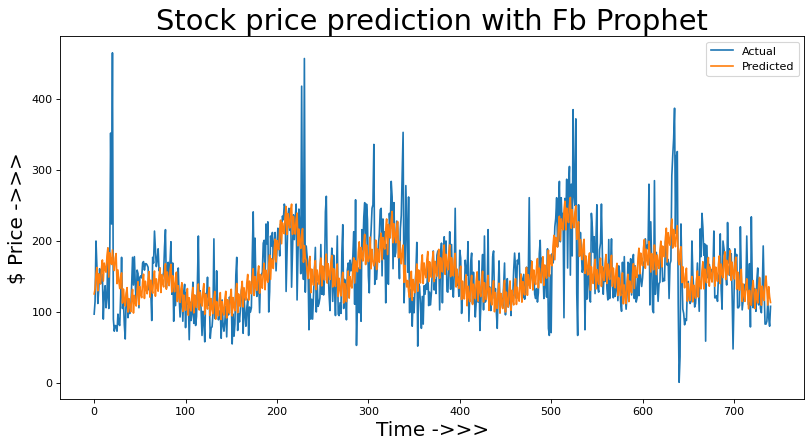

In [ ]:
figure = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time ->>>', fontsize = 18)
plt.ylabel('$ Price ->>>', fontsize = 18)
plt.title('Stock price prediction with Fb Prophet', fontsize = 26)
plt.legend()
plt.show()

In [ ]:
# cross-validation performance
evaluation_model = cross_validation(final_model, initial='714 days', period='26 days', horizon = '10 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

INFO:prophet:Making 5 forecasts with cutoffs between 2022-01-06 00:00:00 and 2022-04-20 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/o0r1pddj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/xjsh5lc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42409', 'data', 'file=/tmp/tmpn53kg2pj/o0r1pddj.json', 'init=/tmp/tmpn53kg2pj/xjsh5lc1.json', 'output', 'file=/tmp/tmpz56bpqai/prophet_model-20220803064012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/gksc1h4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn53kg2pj/ldry79i2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.030966,0.175970,0.172360,0.035175,0.033262,0.034832,1.0
5,6 days,0.049025,0.221417,0.198432,0.038224,0.027728,0.038932,1.0
6,7 days,0.061610,0.248213,0.194758,0.040618,0.023560,0.039558,1.0
3,4 days,0.063664,0.252317,0.242696,0.047163,0.043358,0.047820,1.0
7,8 days,0.072796,0.269808,0.229918,0.046632,0.044665,0.046748,1.0


In [ ]:
np.expm1(y_pred)[-7:]

array([127.84207882, 139.38820604, 119.9193028 , 107.38650507,
       125.8619763 , 113.35548649, 110.28049437])

In [ ]:
y_true.isna().sum()

AttributeError: ignored

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_true, y_pred))

0.34881993256386523
